## Linear regression

### Problem
Build a model and predict pricing of the apartment rent in Graz based on data in the ad

### Goals

- Manually write linear regression algorithm
    - Gradient descent function
    - Cost function implementation
    - Normal equation function
    - Feature enumeration and normalization function
- Use libraries and compare it with manual result

### Data description

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Area | Objective Feature | area | float (square meters) |
| Rooms number | Objective Feature | rooms | string  |
| Zip code | Objective Feature | zip | string |
| District | Objective Feature | district | string |
| Is the ad private| Objective Feature | is_private | boolean |
| Is the flat in the city center | Objective Feature | center | boolean |
| Pricing of the ad | Target Variable | price | float |

### Data selection

In [62]:
# We will make a copy of the dataset
X = df.loc[:, ~df.columns.isin(['price', 'advertiser', 'link-href', 'is_private', 'zip', 'district'])]
y = df['price']

In [63]:
X

,area,rooms,center
1,100.0,3,False
2,90.0,3,False
3,21.0,1,True
4,50.0,2,False
5,103.0,3,False
...,...,...,...
3672,53.0,3,False
3673,60.0,3,False
3674,67.0,3,False
3675,105.0,3,True


In [64]:
y.head()

1    996.78
2    700.00
3    322.07
4    671.00
5    749.00
Name: price, dtype: float64

### Categorical features enumeration

In [65]:
def cats_to_codes(df, feature, ordered=None):
    return dict(df[feature].value_counts().astype('category').cat.codes)

In [66]:
def codes_to_cats(feature, code_dict):
    return {value:key for key, value in code_dict.items()}

zip_codes = cats_to_codes(X, 'zip')
X.zip = X.zip.map(zip_codes)

In [67]:
X.head()

,area,rooms,center
1,100.0,3,False
2,90.0,3,False
3,21.0,1,True
4,50.0,2,False
5,103.0,3,False


In [68]:
rooms_codes = cats_to_codes(X, 'rooms')
X.rooms = X.rooms.map(rooms_codes)

/opt/miniconda3/envs/mlenv/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [69]:
X.head()

,area,rooms,center
1,100.0,2,False
2,90.0,2,False
3,21.0,1,True
4,50.0,3,False
5,103.0,2,False


district_codes = cats_to_codes(X, 'district')
X.district = X.district.map(district_codes)

In [70]:
#X.is_private = X.is_private.astype('int')
X.center = X.center.astype('int')

/opt/miniconda3/envs/mlenv/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [71]:
X

,area,rooms,center
1,100.0,2,0
2,90.0,2,0
3,21.0,1,1
4,50.0,3,0
5,103.0,2,0
...,...,...,...
3672,53.0,2,0
3673,60.0,2,0
3674,67.0,2,0
3675,105.0,2,1


### Feature normalization

In [72]:
mean_X = np.mean(X)
std_X = np.std(X)

In [73]:
def normalize(x, mean, std):
    return (x - mean)/std

In [74]:
for feat in X.columns:
    X[feat] = (X[feat] - mean_X[feat])/std_X[feat]

<ipython-input-74-3033a60703a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = (X[feat] - mean_X[feat])/std_X[feat]


In [75]:
X

,area,rooms,center
1,1.918100,-0.281292,-0.740279
2,1.443325,-0.281292,-0.740279
3,-1.832624,-1.399363,1.350843
4,-0.455776,0.836779,-0.740279
5,2.060533,-0.281292,-0.740279
...,...,...,...
3672,-0.313343,-0.281292,-0.740279
3673,0.018999,-0.281292,-0.740279
3674,0.351342,-0.281292,-0.740279
3675,2.155488,-0.281292,1.350843


## First hyphotesis
$$
h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3 + 
\theta_4 x_4 + \theta_5 x_5 + \theta_6 x_6  
$$

### Adding of intercept term x0

In [76]:
X.insert(loc=0, column='x0', value=np.ones(len(X)))

In [77]:
X

,x0,area,rooms,center
1,1.0,1.918100,-0.281292,-0.740279
2,1.0,1.443325,-0.281292,-0.740279
3,1.0,-1.832624,-1.399363,1.350843
4,1.0,-0.455776,0.836779,-0.740279
5,1.0,2.060533,-0.281292,-0.740279
...,...,...,...,...
3672,1.0,-0.313343,-0.281292,-0.740279
3673,1.0,0.018999,-0.281292,-0.740279
3674,1.0,0.351342,-0.281292,-0.740279
3675,1.0,2.155488,-0.281292,1.350843


### Conversion of X and y to numpy arrays 

In [78]:
X = X.to_numpy()
y = y.to_numpy().reshape((-1, 1))

In [79]:
X.shape, y.shape

((3466, 4), (3466, 1))

In [80]:
def computeCost(X, y, theta):
    m = len(y) 
    J = 1/(2*m) * np.sum(np.power(np.subtract(X.dot(theta), y), 2))
    return J

In [81]:
theta = np.zeros((X.shape[1], 1))

In [82]:
theta.shape

(4, 1)

In [83]:
computeCost(X, y, theta)

263974.43644081074

In [84]:
def gradientDescent(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = np.zeros((num_iters, 1))
    for i in range(num_iters):
        error = X.dot(theta) - y
        theta = theta - (alpha/m) * X.T.dot(error)
        J_history[i] = computeCost(X, y, theta)
    return theta, J_history

In [85]:
new_theta, J_history = gradientDescent(X, y, theta, 0.1, 100)

In [86]:
computeCost(X, y, new_theta)

5609.476648950775

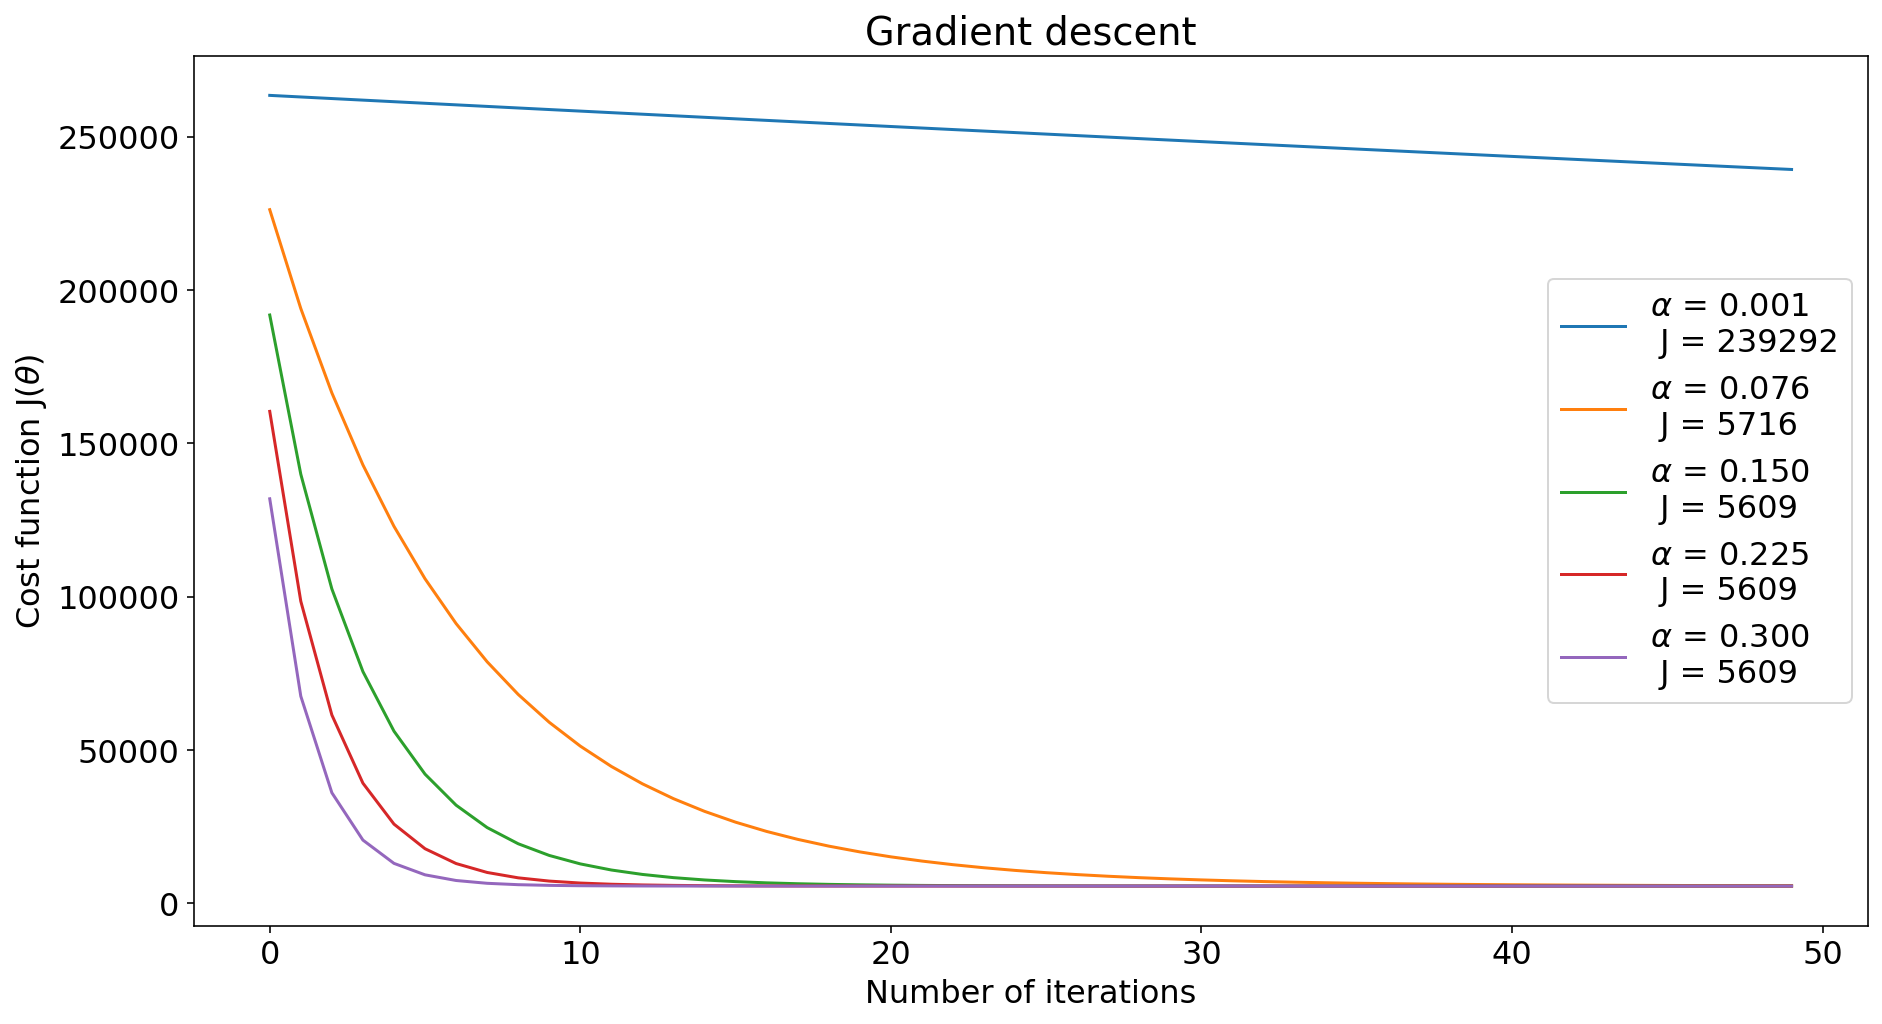

In [87]:
plt.figure(figsize=(15,8));

alphas = np.linspace(0.001, 0.3, 5)
for a in alphas:
    _, J_history = gradientDescent(X, y, theta, a, 50)
    plt.plot(np.arange(J_history.shape[0]), J_history, label=(r'$\alpha$ = {:1.3f}'.format(a) \
                                                              + '\n J = {}'.format(int(J_history[-1][0]))))

plt.legend()
plt.xlabel('Number of iterations');
plt.ylabel(r'Cost function J($\theta$)')
plt.title("Gradient descent");

### Quick test for hyphothesis

In [88]:
new_theta, J_history = gradientDescent(X, y, theta, 0.1, 100)

In [89]:
new_theta

array([[696.47824272],
       [177.69009833],
       [ -4.83151891],
       [ -6.45989967]])

In [90]:
mean_X, std_X

(area      59.599827
 rooms      2.251587
 center     0.354010
 dtype: float64,
 area      21.062597
 rooms      0.894398
 center     0.478212
 dtype: float64)

In [91]:
f = [44, 1, 1]
x = []

for i in range(mean_X.shape[0]):
    x.append(normalize(f[i], mean_X[i], std_X[i]))

In [92]:
x = [1,] + x

In [93]:
x = np.array(x)

In [94]:
new_theta.T.dot(x)

array([562.90837808])

Looks valid

## Model validation

In [96]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [97]:
def predict(X, theta):
    return X.dot(theta)

In [98]:
theta

array([[0.],
       [0.],
       [0.],
       [0.]])

In [99]:
new_theta, _ = gradientDescent(train_X, train_y, theta, 0.1, 100)

In [100]:
val_predictions = predict(val_X, new_theta)

In [101]:
print(val_predictions[:10])

[[ 768.22493417]
 [ 577.35782165]
 [ 851.11817124]
 [ 692.52226332]
 [1014.75103101]
 [ 448.74502025]
 [ 547.08664618]
 [1305.48778157]
 [ 653.0604925 ]
 [ 490.80205961]]


In [102]:
print(val_y[:10])

[[ 895.  ]
 [ 550.  ]
 [ 745.  ]
 [ 728.43]
 [ 999.24]
 [ 400.  ]
 [ 396.5 ]
 [1453.63]
 [ 545.  ]
 [ 495.  ]]


### Calculation of the Mean Absolute Error in Validation Data

In [103]:
from sklearn.metrics import mean_absolute_error
val_mae = mean_absolute_error(val_y, val_predictions)

In [104]:
val_mae

81.99833975564626

## Normal equation

$$
\theta = (X^T X)^{-1}X^T \bar{y}
$$

In [105]:
def normalEqn(X, y):
    m = len(y)
    theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [106]:
norm_theta = normalEqn(X, y)

Should be more accurate

In [107]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [108]:
val_predictions = predict(val_X, norm_theta)

In [109]:
val_mae = mean_absolute_error(val_y, val_predictions)
val_mae

81.77967776329322

## Predicting prices usign scikit linear regressor

In [116]:
X

array([[ 1.        ,  1.91810027, -0.28129196, -0.74027867],
       [ 1.        ,  1.44332501, -0.28129196, -0.74027867],
       [ 1.        , -1.83262429, -1.39936299,  1.35084265],
       ...,
       [ 1.        ,  0.35134191, -0.28129196, -0.74027867],
       [ 1.        ,  2.1554879 , -0.28129196,  1.35084265],
       [ 1.        ,  0.01899923,  0.83677907, -0.74027867]])

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [111]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression(fit_intercept=False, n_jobs=-1)
regressor.fit(X_train, y_train)

LinearRegression(fit_intercept=False, n_jobs=-1)

In [112]:
print('Weight coefficients: ', regressor.coef_)

Weight coefficients:  [[697.93071978 177.18853113  -6.41221045  -6.80762635]]


In [113]:
y_pred_train = regressor.predict(X_test)

In [114]:
y_pred_train[0:10]

array([[ 768.27088716],
       [ 577.37337948],
       [ 851.1524518 ],
       [ 692.55862927],
       [1014.82198061],
       [ 448.69995031],
       [ 547.06025391],
       [1305.52904003],
       [ 653.08563736],
       [ 490.76231581]])

In [115]:
val_mae = mean_absolute_error(y_test, y_pred_train)
val_mae

81.99522722251697